### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 3 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 03 мая, -4 балла после 08:30 10 мая, -6 баллов после 08:30 17 мая, -8 баллов после 08:30 24 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [69]:
def classification_error_impurity(labels):
    p = np.bincount(labels.astype(int)) / labels.size
    return (1 - np.max(p) if p.size > 0 else 0)

def gini_impurity(labels):
    p = np.bincount(labels.astype(int)) / labels.size
    return 1 - np.dot(p, p)

def entropy_impurity(labels):
    p = np.bincount(labels.astype(int)) / labels.size
    p[p == 0] = 1 # меняем, чтобы логарифм нормально считался
    return -np.dot(p, np.log(p))


class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        
        if self.criterion == 'classification_error':
            self.impurity = classification_error_impurity
        elif self.criterion == 'gini':
            self.impurity = gini_impurity
        elif self.criterion == 'entropy':
            self.impurity = entropy_impurity
        
        self.used_features = []
        self.importances = dict()
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        # Ваш код здесь
        selected_feature = 0
        selected_threshold = 0
        max_gain = 0
        
        for feature_id in range(x.shape[1]):
                for feature_val in np.unique(x[:, feature_id]):
                    x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, feature_val)
                    n_left = x_left.shape[0]
                    n_right = x_right.shape[0]
                    info_gain = (self.impurity(y) - 
                                (n_left / x.shape[0]) * self.impurity(y_left) - 
                                (n_right / x.shape[0]) * self.impurity(y_right))
                    if info_gain > max_gain:
                        selected_feature = feature_id
                        selected_threshold = feature_val
                        max_gain = info_gain
        self.used_features.append(selected_feature)
        
        if selected_feature in self.importances.keys():
            self.importances[selected_feature] += max_gain
        else:
            self.importances[selected_feature] = max_gain
        return selected_feature, selected_threshold
    
    
    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # Ваш код здесь
        #print('Fitting node', node_id, '...')
        if (x.shape[0] >= self.min_samples_split and depth < self.max_depth and len(np.unique(y)) > 1
            and len(self.used_features) < x.shape[1]):
            #  add non-leaf node
            feature_id, threshold = self.__find_threshold(x, y)
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, threshold)
            self.tree[node_id] = (self.NON_LEAF_TYPE, feature_id, threshold)
            if y_left.size != 0:
                self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
            if y_right.size != 0:
                self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
        else:
            #  add leaf node
            class_list, class_probabilities = np.unique(y, return_counts=True)
            class_probabilities = class_probabilities / y.shape[0]
            predict_id = class_list[np.argmax(class_probabilities)]
            predict_prob = class_probabilities[np.argmax(class_probabilities)]
            self.tree[node_id] = (self.LEAF_TYPE, predict_id, predict_prob)

    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.importances

In [70]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [71]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [72]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [73]:
print('scikit tree:', accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print('my tree:', accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

scikit tree: 0.9444444444444444
my tree: 0.9444444444444444


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [85]:
%time clf.fit(X_train, y_train)

Wall time: 996 µs


DecisionTreeClassifier()

In [86]:
%time my_clf.fit(X_train, y_train)

Wall time: 6.94 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [88]:
def encode_feature(df, categ_feature):
    for i in df[categ_feature].unique():
        df[categ_feature + '=' + str(int(i))] = (df[categ_feature] == i).astype(float)
    df = df.drop([categ_feature], axis=1)
    return df

def preproc(df_init):
    df = df_init.copy()
    df = df.iloc[:, :97]
    
    df = df.drop(['id'], axis = 1)
    df = df.drop(['idg'], axis = 1)
    df = df.drop(['condtn'], axis=1)
    df = df.drop(['round'], axis=1)
    df = df.drop(['position', 'positin1'], axis=1)
    df = df.drop(['order'], axis=1)
    df = df.drop(['partner'], axis=1)
    df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)
    df = df.dropna(subset=['age'])
    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df = df.drop(['field'], axis=1)
    df = encode_feature(df, 'field_cd')
    df = df.drop(['undergra'], axis=1)
    df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
    df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].fillna(0.0)
    df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
    df.loc[:, 'tuition'] = df.loc[:, 'tuition'].fillna(0.0)
    df = encode_feature(df, 'race')
    df = df.dropna(subset=['imprelig', 'imprace'])
    df = df.drop(['from', 'zipcode'], axis=1)
    df = df.drop(['income'], axis=1)
    df = df.dropna(subset=['date'])
    df = encode_feature(df, 'goal')
    df = encode_feature(df, 'date')
    df = encode_feature(df, 'go_out')

    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
    df = df.drop(['career'], axis=1)
    #encode career_c
    df = encode_feature(df, 'career_c')
    df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)
    df = df.drop(['expnum'], axis=1)
    
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
    df = df.drop(['temp_totalsum'], axis=1)
    
    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
                'intel{}_1'.format(i), 'fun{}_1'.format(i), 
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)
    
    df = df.drop(['wave'], axis=1)
    df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
    df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
    df_female.columns = df_female.columns + '_f'
    df = df_male.set_index('iid').join(df_female.set_index('pid_f'))
    df = df.drop(['iid_f', 'pid'], axis=1)
    df = df.fillna(value = 0)
    

    return df

In [89]:
df = pd.read_csv('data/speed_dating.csv', encoding='cp1251')
df = df.pipe(preproc)

X = df.copy()
X = X.drop(['match'], axis=1)
y = df['match']

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.9, test_size=0.1, stratify=y.values)

In [90]:
my_clf = MyDecisionTreeClassifier(min_samples_split=1, max_depth=5, criterion='entropy')

In [92]:
my_clf.fit(X_train, y_train)

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [329]:
criterions = ['classification_error', 'gini', 'entropy']
max_depths = [2, 3, 4, 5, 6]
min_splits = [2, 4, 8, 16, 32]

best_criterion = None
best_depth = None
best_split = None
best_accuracy = 0.0

accuracy_matrix = np.zeros(shape=(3,7,5))
crit_dict = {0: 'classification_error', 1: 'gini', 2: 'entropy'}
depth_dict = {0: 2, 1: 3, 2: 4, 3: 5, 4: 6}
split_dict = {0: 2, 1: 4, 2: 8, 3: 16, 4: 32}

kf = KFold(n_splits = 4, shuffle = True)

X = np.array(X)
y = np.array(y)

for criterion in crit_dict.keys():
    for max_depth in depth_dict.keys():
        for min_split in split_dict.keys():
            print('Fitting tree with criterion {}, max_depth={}, min_samples_split={} ...'.\
                  format(crit_dict[criterion], depth_dict[max_depth], split_dict[min_split]))
            clf = MyDecisionTreeClassifier(max_depth=depth_dict[max_depth], min_samples_split=split_dict[min_split],\
                                           criterion=crit_dict[criterion])
            val_scores = []
            split_ind = kf.split(X)
            for train_ind, test_ind in split_ind:
                clf.fit(X[train_ind], y[train_ind])
                val_scores.append(accuracy_score(y[test_ind], clf.predict(X[test_ind])))
            accuracy = np.mean(np.array(val_scores))
            accuracy_matrix[criterion, max_depth, min_split] = accuracy
            print('Accuracy:', accuracy)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_criterion = crit_dict[criterion]
                best_depth = depth_dict[max_depth]
                best_split = split_dict[min_split]



Fitting tree with criterion classification_error, max_depth=2, min_samples_split=2 ...
Accuracy: 0.8409164706846655
Fitting tree with criterion classification_error, max_depth=2, min_samples_split=4 ...
Accuracy: 0.8393473011229295
Fitting tree with criterion classification_error, max_depth=2, min_samples_split=8 ...
Accuracy: 0.8406020062672206
Fitting tree with criterion classification_error, max_depth=2, min_samples_split=16 ...
Accuracy: 0.8396637358688045
Fitting tree with criterion classification_error, max_depth=2, min_samples_split=32 ...
Accuracy: 0.8415477639136713
Fitting tree with criterion classification_error, max_depth=3, min_samples_split=2 ...
Accuracy: 0.8393461189258715
Fitting tree with criterion classification_error, max_depth=3, min_samples_split=4 ...
Accuracy: 0.8418590758056279
Fitting tree with criterion classification_error, max_depth=3, min_samples_split=8 ...
Accuracy: 0.840289906243892
Fitting tree with criterion classification_error, max_depth=3, min_samp

'"\nclf_gini = MyDecisionTreeClassifier(min_samples_split=2, criterion=\'gini\')\nclf_entropy = MyDecisionTreeClassifier(min_samples_split=2, criterion=\'entropy\')\nclf_misclass = MyDecisionTreeClassifier(min_samples_split=2, criterion=\'classification_error\')\n\nX = df.copy()\nX = X.drop(\'match\', axis=1)\ny = df[\'match\']\n\nX_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.1, test_size=0.1, stratify=y.values)\n\nclf_gini.fit(X_train, y_train)\nclf_entropy.fit(X_train, y_train)\nclf_misclass.fit(X_train, y_train)\n\nprint(\'Gini:\', accuracy_score(y_pred=clf_gini.predict(X_train), y_true=y_train))\nprint(\'Entropy:\', accuracy_score(y_pred=clf_entropy.predict(X_train), y_true=y_train))\nprint(\'Classification error:\', accuracy_score(y_pred=clf_misclass.predict(X_train), y_true=y_train))\n'

In [330]:
print(best_criterion, best_depth, best_split)

entropy 3 2


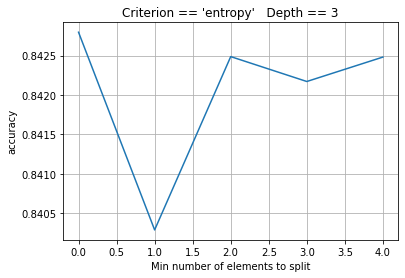

In [355]:
plt.plot(accuracy_matrix[2, 1, :])
plt.xlabel('Min number of elements to split')
plt.ylabel('accuracy')
plt.title('Criterion == \'entropy\'   Depth == 3')
plt.grid()
plt.show()


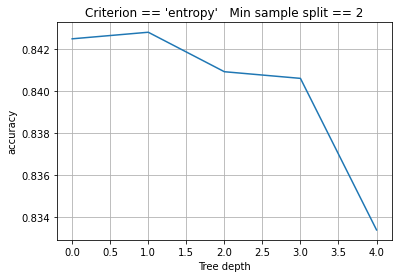

In [358]:
plt.plot(accuracy_matrix[2, :5, 0])
plt.xlabel('Tree depth')
plt.ylabel('accuracy')
plt.title('Criterion == \'entropy\'   Min sample split == 2')
plt.grid()
plt.show()


## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [93]:
df = pd.read_csv('data/speed_dating.csv', encoding='cp1251')
df = df.pipe(preproc)

X = df.copy()
X = X.drop('match', axis=1)
y = df['match']

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.9, test_size=0.1, stratify=y.values)

clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='entropy')
clf.fit(X_train, y_train)

In [94]:
importances = clf.get_feature_importance()
sorted_importances = [k for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=True)]

list(X.columns[sorted_importances])[:10]

['int_corr',
 'goal=2',
 'exphappy',
 'sinc4_1',
 'samerace',
 'shar4_1',
 'age',
 'intel1_1',
 'amb4_1',
 'sinc3_1']

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

In [97]:
# Обработка категориальных признаков, обработка nan'ов

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



In [98]:
# Всё понравилось (особенно датасет)